# How to use tensorflow_datasets
Recently TensorFlow released a new Python package called [tensorflow_datasets](https://www.tensorflow.org/datasets). This makes it incredibly easy to load data. You only have to pass the name of the dataset, and the split you want to load. Their website contains a lot of interesting datasets. 

Here I will be loading the beans dataset: 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("The TensorFlow version used in this tutorial is", tf.__version__)

ds = tfds.load('beans', split='train', shuffle_files=True)

The TensorFlow version used in this tutorial is 2.3.0


This gives you a simple `tf.compat.v2.data.Dataset` object with an additional `options` part. You will be most interested in what you can do with the dataset. First of all, before doing any training, you can visualise the images and the labels: 

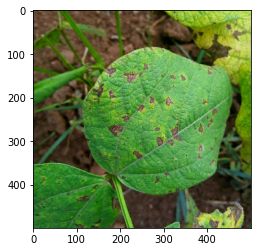

0


In [2]:
for index, a in enumerate(ds):
    plt.imshow(a['image'])
    plt.show()
    print(a['label'].numpy())
    if index >=0: 
        break

You can also resize the images by applying a function to the inputs using the `dataset.map` function. Note that the dataset contains both image and label in a dictionary. If you simply apply an image resizing function you will get a `TypeError: Expected any non-tensor type, got a tensor instead.`. You always have to augment only the image, and leave the label alone (e.g. pass it back without doing anything with it). Don't forget to pass the label, otherwise you can't train your neural network anymore. 


In [3]:
def augment_hue(tensor):
    return tf.image.resize(tensor['image'], (62,62)), tensor['label']

def normalize_image(image, label):
    return image / 255.0 , label

resized_dataset = ds.map(map_func=augment_hue)
normalized_dataset = resized_dataset.map(map_func=normalize_image)


Now you can visualise this new resized dataset. Be aware that at this point the values are still between 0 and 255...


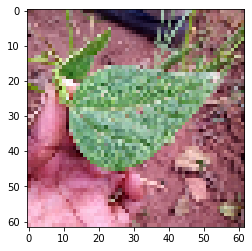

1


In [4]:
for index, (image, label) in enumerate(resized_dataset):
    plt.imshow(image / 255.0)
    plt.show()
    print(label.numpy())
    if index >=0: 
        break

If you get the error `AttributeError: module tensorflow._api.v2.train has no attribute AdamOptimizer`, make sure you use `tf.optimizers.Adam` instead. 

In [5]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(62,62, 3)),
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


# Compile and train the model for one epoch... It's only to have something trained, not get the best score
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)


Now you can feed the dataset to your keras.fit function. Note that to do this you likely want to repeat and batch the dataset. If you get `ValueError: When providing an infinite dataset, you must specify the number of steps to run (if you did not intend to create an infinite dataset, make sure to not call repeat() on the dataset).`make sure you provide the `steps_per_epoch` argument. 


In [6]:
BATCH_SIZE = 8
dataset = normalized_dataset.repeat().batch(BATCH_SIZE)

model.fit(dataset, steps_per_epoch=len(ds)/BATCH_SIZE, epochs=3)

Epoch 1/3
130/129 [==============================] - 5s 39ms/step - loss: 1.0976 - accuracy: 0.3587
Epoch 2/3
130/129 [==============================] - 5s 38ms/step - loss: 1.0393 - accuracy: 0.4644
Epoch 3/3
130/129 [==============================] - 5s 39ms/step - loss: 0.9905 - accuracy: 0.5327


Evaluating is also easy, as long as you apply the same methods you applied to the train dataset to the test dataset. All you need to do to load the test dataset is changing the `split` argument. Evaluating the performance is already part of Keras `model.evaluate`. 

In [7]:
test_dataset = tfds.load('beans', split='test')
test_dataset = test_dataset.map(map_func=augment_hue).map(map_func=normalize_image).batch(BATCH_SIZE)
model.evaluate(test_dataset)

16/16 [==============================] - 0s 13ms/step - loss: 0.9792 - accuracy: 0.4922


[0.9792062640190125, 0.4921875]